### Notebook to genereate time-pressure series from TC output

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
September 2022

In [143]:
from netCDF4 import Dataset
import numpy as np
import matplotlib
# matplotlib.use('pdf')
import matplotlib.pyplot as plt
# import matplotlib.colors as colors
from matplotlib import ticker, cm
import sys
import subprocess
import cartopy
from thermo_functions import density_moist, theta_dry, theta_equiv, theta_virtual, relh
from mask_tc_track import mask_tc_track

#### Settings

In [2]:
# #### Variable selection

# Fill variable
iplot = 'vmf'
# options: vmf, thv, the, qrad

# Calculate anomaly as deviation from xy-mean
do_prm_xy = 0

# Should be off for VMF
if iplot == 'vmf':
  do_prm_xy=0

# Strat/Conv index subset
istrat=2 # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
if istrat == -1:
  fig_extra=''
elif istrat == 0:
  fig_extra='_nonrain'
elif istrat == 1:
  fig_extra='_conv'
elif istrat == 2:
  fig_extra='_strat'
#fig_extra=''

# TC tracking
ptrack='600' # tracking pressure level
var_track = 'rvor' # variable
rmax = 8 # radius (deg) limit to keep unmasked

# #### Test/storm selection
storm = 'haiyan'
#storm = 'maria'

# Tests to read and compare
itest = 'ctl'

# Starting member to read
memb='memb_01'

# #### Time selection
nd = 3 # ndays
nt = nd*24
hr_tag = str(np.char.zfill(str(nt), 2))

#### Directories

In [3]:
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"

datdir2 = 'post/d02/'

#### Get dimensions

In [4]:
process = subprocess.Popen(['ls '+main+storm+'/memb_01/ctl/wrfout_d02_*'],shell=True,
    stdout=subprocess.PIPE,universal_newlines=True)
output = process.stdout.readline()
wrffil = output.strip() #[3]
varfil_main = Dataset(wrffil)
lat = varfil_main.variables['XLAT'][:][0] # deg
lon = varfil_main.variables['XLONG'][:][0] # deg
lat1d = lat[:,0]
lon1d = lon[0,:]
nx1 = lat1d.size
nx2 = lon1d.size
varfil_main.close()

datdir = main+storm+'/'+memb+'/ctl/'+datdir2
varfil_main = Dataset(datdir+'T.nc')
nz = varfil_main.dimensions['level'].size
pres = varfil_main.variables['pres'][:] # hPa
varfil_main.close()

#### Read variables

In [5]:
if itest == 'ctl':
  t0=36
elif itest == 'ncrf':
  t0=0
elif itest == 'crfon':
  t0=0

t0+=1 # add one time step since NCRF(t=0) = CTL
t1 = t0+nt

print('Running itest: ',itest)

datdir = main+storm+'/'+memb+'/'+itest+'/'+datdir2

# Two-dimensional variables

# Stratiform index
if istrat != -1:
  varfil_main = Dataset(datdir+'strat.nc')
  strat = varfil_main.variables['strat'][t0:t1,:,:,:] # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
  varfil_main.close()

Running itest:  ctl


In [24]:
# 10m winds
varfil_main = Dataset(datdir+'U10.nc')
u = varfil_main.variables['U10'][t0:t1,:,:,:] # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
varfil_main.close()
varfil_main = Dataset(datdir+'V10.nc')
v = varfil_main.variables['V10'][t0:t1,:,:,:] # 0-non-raining, 1-conv, 2-strat, 3-other/anvil
varfil_main.close()

In [145]:
# Get azimuthal winds
# Get azimuthally averaged winds based on TC track

track_file = datdir+'../../track_'+var_track+'_'+ptrack+'hPa.nc'
rad_azim = 4 # deg
vtan = azim_wind_latlon(track_file, u, v, lon, lat, rad_azim)
print(vtan)


In [149]:
# Function to convert wind from (time,lat,lon) to the azimuthal-maximum tangential
#   wind as f(time) based on a TC track.
# 
# INPUTS:
#       track_file - file path and name for netCDF file containing track as clon,clat
#           (generated by the program run_tracking.py)
#       rmax - radius limit [degrees lon/lat]
#       u - zonal wind as (time,x,y) (note, the order of x,y is arbitrary)
#       v - meridional wind " "
#       lon - array of longitude points as (x,y) [deg]
#       lat - " " latitude points
#       t0, t1 - bounding time indices of var, assuming shorter in time than clon/clat
# 
# RETURNS:
#       returns a masked array of identical shape to var.
# 
# James Ruppert  
# jruppert@ou.edu  
# September 2022

# from netCDF4 import Dataset
# import numpy as np

def azim_wind_latlon(track_file, u, v, lon, lat, rmax):

    # Read TC track
    ncfile = Dataset(track_file)
    clon = ncfile.variables['clon'][:] # deg
    clat = ncfile.variables['clat'][:] # deg
    ncfile.close()

    # Center grid on track
    lon4d = np.repeat(lon[np.newaxis,np.newaxis,:,:], nt, axis=0)
    lat4d = np.repeat(lat[np.newaxis,np.newaxis,:,:], nt, axis=0)
    lon4d -= clon[t0:t1,np.newaxis,np.newaxis,np.newaxis]
    lat4d -= clat[t0:t1,np.newaxis,np.newaxis,np.newaxis]

    # Get radius and azimuth
    radius4d = np.sqrt( lon4d**2 + lat4d**2 )
    azim = np.arctan(lat4d/lon4d)
    azim[(lon4d < 0 )] += np.pi

    # Get tangential wind
    vtx = u*np.sin(azim)
    vty = v*np.cos(azim)
    v_tan = vty - vtx
    v_tan_mask = np.ma.masked_where(radius4d > rmax, v_tan)
    v_tan_max = np.max(v_tan_mask, axis=(1,2,3))
    return v_tan_max

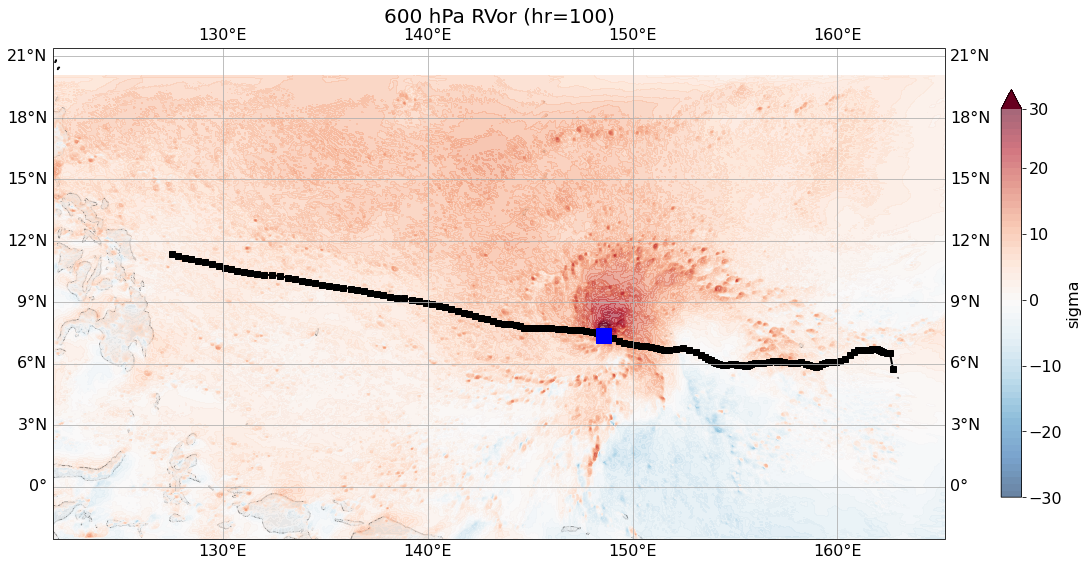

In [157]:
# select plotting area
plt_area=[np.min(lon1d), np.max(lon1d), np.min(lat1d), np.max(lat1d)] # W,E,S,N
# plt_area=[145, np.max(lon), 0, 15] # W,E,S,N

# tsel=36
# for tsel in range(5,nt,6):
for tsel in range(100,101):
    
    hr_tag = str(np.char.zfill(str(tsel), 3))
    
    pltvar=v_tan[tsel-t0,0,:,:]

    # create figure
    fig = plt.figure(figsize=(20,10))
    ax = fig.add_subplot(111,projection=cartopy.crs.PlateCarree())
    ax.set_title('600' + ' hPa RVor (hr='+hr_tag+')', fontsize=20)

    # fill contour
    clevs = np.arange(-30,30)

    im = ax.contourf(lon, lat, pltvar, clevs, cmap='RdBu_r', alpha=0.6,
                     extend='max', zorder=2)

    cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator())
    cbar.ax.set_ylabel('sigma')
            # cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=ticker.AutoLocator)

    # storm track
    plt.plot(clon, clat, color="black", linewidth=2)
    plt.plot(clon, clat, "s", color="black")
    # current time
    plt.plot(clon[tsel], clat[tsel], "s", color="blue", markersize=15)
    # all-time max (time step 168)
    # plt.plot(lon1d[mloc2[2]], lat1d[mloc2[1]], "s", color="blue", markersize=15)

    # add map features
    ax.add_feature(cartopy.feature.LAND,facecolor="lightgray") #land color
    # ax.add_feature(cartopy.feature.OCEAN) #ocean color
    ax.add_feature(cartopy.feature.COASTLINE)
    # ax.add_feature(cartopy.feature.STATES)
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)

    # Zoom into selected area (comment this out to plot entire available area)
    ax.set_extent(plt_area)

    plt.show()
    # plt.close()

In [6]:
# Three-dimensional variables if needed

if iplot == 'thv' or iplot == 'the' or iplot == 'vmf' or iplot == 'rh':
# Mixing ratio
  varfil_main = Dataset(datdir+'QVAPOR.nc')
  qv = varfil_main.variables['QVAPOR'][t0:t1,:,:,:] # kg/kg
  varfil_main.close()
# Temp
  varfil_main = Dataset(datdir+'T.nc')
  tmpk = varfil_main.variables['T'][t0:t1,:,:,:] # K
  varfil_main.close()

In [7]:
# ### Variable selection ##############################################

# if iplot == 'thv':
# # Virtual potential temp
#   var = theta_virtual(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # K
# elif iplot == 'the': 
# # Equiv potential temp
#   var = theta_equiv(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # K
# elif iplot == 'vmf':
# # Vertical mass flux
#   # Vertical motion
#   varfil = Dataset(datdir+'W.nc') # this opens the netcdf file
#   var = varfil.variables['W'][t0:t1,:,:,:] # m/s
#   varfil.close()
#   # Density
#   # rho = density_moist(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # kg/m3
#   var *= density_moist(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # kg/m3
# elif iplot == 'rh':
# # Humidity
#   var = relh(qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2,tmpk,ice=1) # %
# elif iplot == 'qrad':
# # Radiation
#   varfil = Dataset(datdir+'RTHRATLW.nc') # this opens the netcdf file
#   var = varfil.variables['RTHRATLW'][t0:t1,:,:,:]*3600*24 # K/s --> K/d
#   varfil.close()
#   varfil = Dataset(datdir+'RTHRATSW.nc') # this opens the netcdf file
#   var += varfil.variables['RTHRATSW'][t0:t1,:,:,:]*3600*24 # K/s --> K/d
#   varfil.close()

#### Use track to mask out, then average

In [8]:
def mask_and_avg(var):
    # Localize to TC track
    track_file = datdir+'../../track_'+var_track+'_'+ptrack+'hPa.nc'
    var_mask = mask_tc_track(track_file, rmax, var, lon, lat, t0, t1)
    
    # Average in x,y
    var_tser = np.mean(var_mask,axis=(2,3))
    
    return var_tser

---
### Plotting routines

In [9]:
# if iplot == 'thv':
#     # Figure settings
#     fig_title=r"$\theta_v$"
#     fig_tag='thv'
#     units_var='K'
#     cmax=5
#     cmin=-1.*cmax
# elif iplot == 'the':
#     # Figure settings
#     fig_title=r"$\theta_e$"
#     fig_tag='the'
#     units_var='K'
#     cmax=5
#     cmin=-1.*cmax
# elif iplot == 'vmf':
#     # Figure settings
#     fig_title='VMF'
#     fig_tag='vmf'
#     units_var='kg m$^{-2}$ s$^{-1}$'
#     cmax=20
#     cmin=-1.*cmax
# elif iplot == 'rh':
#     # Figure settings
#     fig_title='RH'
#     fig_tag='rh'
#     units_var='-'
#     cmax=100
#     cmin=40
# elif iplot == 'qrad':
#     # Figure settings
#     fig_title='$Q_R$'
#     fig_tag='qrad'
#     units_var='K d$^{-1}$'
#     cmax=5
#     cmin=-1.*cmax

# if do_prm_xy == 1:
#     fig_tag+='_xyp'
#     fig_title+=' (xp)'

In [138]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 16}

matplotlib.rc('font', **font)

#### Vertical mass flux

In [11]:
# Vertical mass flux
# Vertical motion
varfil = Dataset(datdir+'W.nc') # this opens the netcdf file
vmf = varfil.variables['W'][t0:t1,:,:,:] # m/s
varfil.close()
# Density
vmf *= density_moist(tmpk,qv,(pres[np.newaxis,:,np.newaxis,np.newaxis])*1e2) # kg/m3

In [12]:
# Standard masking
# vmf_tser = mask_and_avg(vmf)

# Mask for istrat only
vmf_strat_mask = np.ma.masked_where((np.repeat(strat,nz,axis=1) != istrat), vmf, copy=True)
vmf_tser = mask_and_avg(vmf_strat_mask)

In [13]:
# Figure settings
fig_title='VMF'
fig_tag='vmf'
units_var='kg m$^{-2}$ s$^{-1}$'
cmax=20
cmin=-1.*cmax

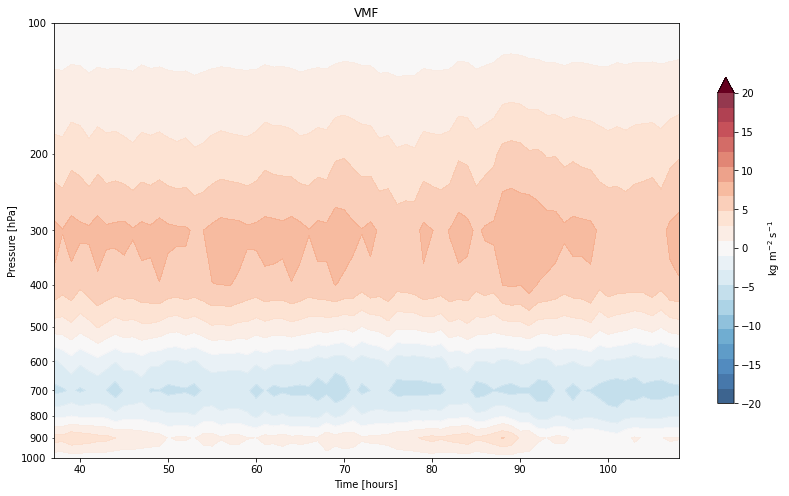

In [14]:
# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title(fig_title)
ax.set_ylabel('Pressure [hPa]')
ax.set_xlabel('Time [hours]')

pltvar = vmf_tser * 1e2

# fill contour
nlevs=21
inc=(cmax-cmin)/nlevs
clevs = np.arange(cmin, cmax+inc, inc)
im = ax.contourf(range(t0,t1), pres, np.transpose(pltvar), clevs, cmap='RdBu_r', alpha=0.8, \
                 extend='max', zorder=2)

cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=matplotlib.ticker.AutoLocator())
cbar.ax.set_ylabel(units_var)
ax.invert_yaxis()
ax.set_yscale('log')
# ax.set_xscale(log_x)
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

# # line contour
# # clevs = np.arange(lcmin, lcmax, lcint)
# clevs = [0.1,0.5,1,2,5,10,50,100,500,1000,2000,3000]
# clevs = np.concatenate((-1*np.flip(clevs),clevs))
# cpltvar=binvar_c_mn
# im = ax.contour(bins[0:nbins-1], pres, np.transpose(cpltvar), clevs, colors='black', zorder=2)
# ax.clabel(im, im.levels, inline=True, fontsize=13)

plt.show()
# plt.savefig(figdir+figtag+'_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)

#### Relative humidity

In [15]:
# Rel hum
relh = relh(qv,pres[np.newaxis,:,np.newaxis,np.newaxis]*1e2,tmpk,ice=1) # %
# var_tser = mask_and_avg(var)

In [16]:
relh_tser = mask_and_avg(relh)

In [17]:
# Standard masking
# relh_tser = mask_and_avg(relh)

# Mask for istrat only
relh_strat_mask = np.ma.masked_where((np.repeat(strat,nz,axis=1) != istrat), relh, copy=True)
relh_tser = mask_and_avg(relh_strat_mask)

In [18]:
# Figure settings
fig_title='RH'
fig_tag='rh'
units_var='%'
cmax=100
cmin=40

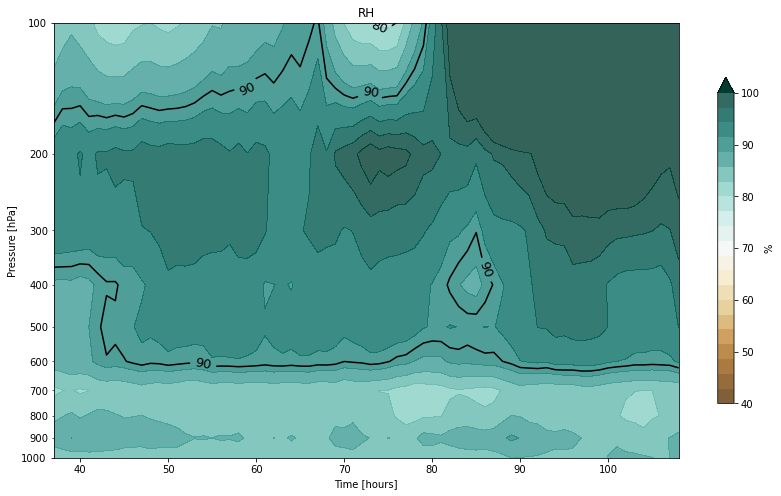

In [19]:
# create figure
fig = plt.figure(figsize=(14,8))
ax = fig.add_subplot(111)

ax.set_title(fig_title)
ax.set_ylabel('Pressure [hPa]')
ax.set_xlabel('Time [hours]')

pltvar = relh_tser

# fill contour
nlevs=21
inc=(cmax-cmin)/nlevs
clevs = np.arange(cmin, cmax+inc, inc)
im = ax.contourf(range(t0,t1), pres, np.transpose(pltvar), clevs, cmap='BrBG', alpha=0.8, \
                 extend='max', zorder=2)

cbar = plt.colorbar(im, ax=ax, shrink=0.75, ticks=matplotlib.ticker.AutoLocator())
cbar.ax.set_ylabel(units_var)
ax.invert_yaxis()
ax.set_yscale('log')
# ax.set_xscale(log_x)
ax.yaxis.set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.ScalarFormatter())

# line contour
# clevs = np.arange(lcmin, lcmax, lcint)
clevs = range(10,100,10)
cpltvar = pltvar
im = ax.contour(range(t0,t1), pres, np.transpose(cpltvar), clevs, colors='black', zorder=2)
ax.clabel(im, im.levels, inline=True, fontsize=13)

plt.show()
# plt.savefig(figdir+figtag+'_compcross_'+imemb+'_'+ivar_select+'.png',dpi=200, facecolor='white', \
#             bbox_inches='tight', pad_inches=0.2)